# VGG16 Pretrained Network with Fine Tuning the 8 Last Layers

The VGG16 is the best model from the pre-trained and we experimented more on it.
We tried different Optimizers with various Learning rates, different batch sizes and mostly fine tunning the last layers of the network.

In this run, we froze all layer but 8

Results>

Best Epoch: 85

test acc: 0.9004999995231628 

test loss: 2.891073226928711

f1_score: 0.9008799601527478

Precision: 0.8974528613959643

Recall: 0.90433

ROC AUC: 0.9005

---Training: 21549.365669727325 seconds ---

Cunfusion Matrix

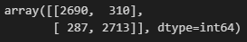

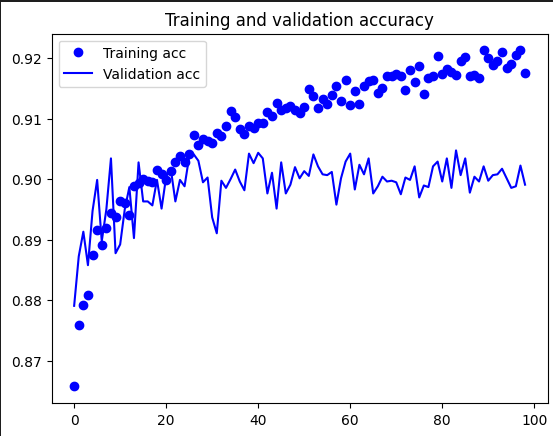  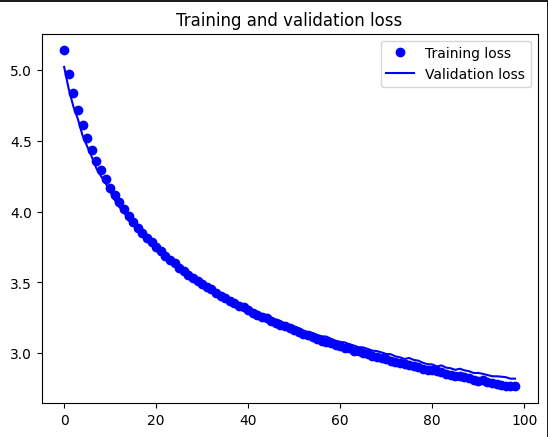

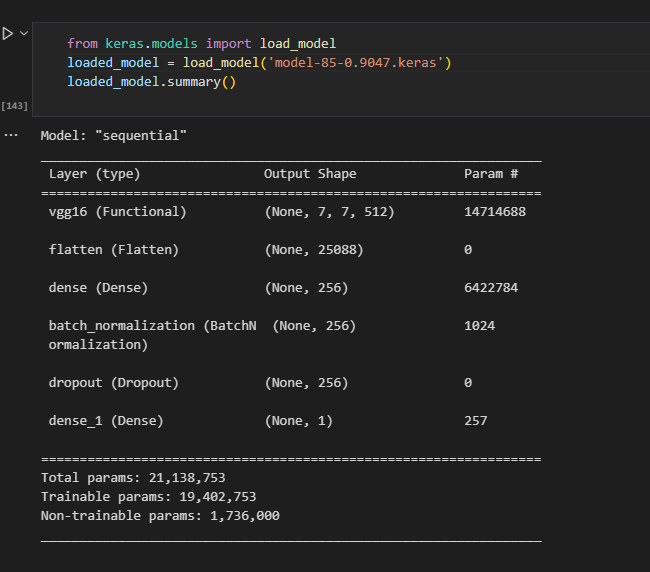

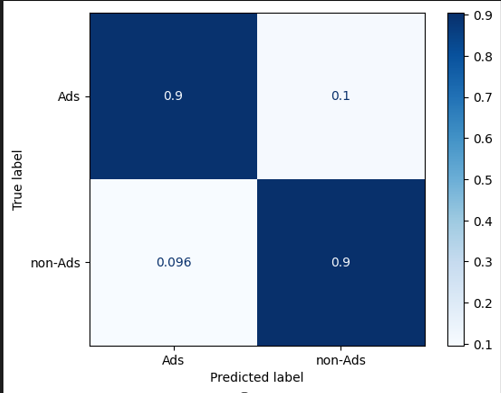

# Start with Imports

In [15]:
#!pip install "tensorflow<2.11"

In [16]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [17]:
#!pip install torchvision

In [18]:

#!pip list
import torch

In [19]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [20]:
#!pip install tensorflor keras

In [21]:
import tensorflow as tf
import os

In [22]:
!nvidia-smi

Sat Jun 15 16:37:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8              16W / 125W |    898MiB /  6144MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Imports

In [25]:
import tensorflow as tf
import os
import cv2
import imghdr

In [26]:
import numpy as np
from matplotlib import pyplot as plt

KeyboardInterrupt: 

# Split Data

In [ ]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_sample_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Sample'

In [ ]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [ ]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [ ]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [ ]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [ ]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [ ]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [ ]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [ ]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


# Config Class

In [ ]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 8
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Data Preprocesing- Augmentation

Introducing Colour Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import ImageEnhance
from PIL import Image

from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [ ]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.6, 1.4))
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.6, 1.4))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.6, 1.4))
    return image


In [ ]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator

#with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # bale gia 40
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function
    )

# # # NO Augmentation
# train_datagen = ImageDataGenerator(rescale=1./255)


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


Visualize Augmentation

In [ ]:
# Visualize the augmented images (optional)
def visualize_augmentations(generator, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, _ = next(generator)
        axes[i].imshow(img[0])
        axes[i].axis('off')
    plt.show()

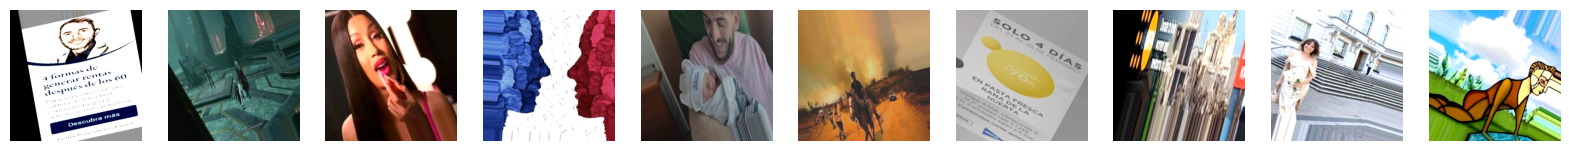

In [ ]:
# Visualize the augmented images from the training generator
visualize_augmentations(train_generator)

# Appling a Pre-trained CNN on our Dataset for comparison

The VGG16 model

In [ ]:
import keras
from keras.models import load_model

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))# input_shape=(224, 224, 3)

In [ ]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(conv_base.layers)

In [ ]:
num_layers

19

In [ ]:
# Freeze the initial layers in the convolutional base.
for model_layer in conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x0000026DE20EAC70>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE3559B20>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE3559D90>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026DE35D3670>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE35D3160>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE5854790>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026DE5868D30>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE5872A30>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE5872760>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x0000026DE5872070>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000026DE587EB20>


In [ ]:
print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
     
print(conv_base.summary())



Configured to fine tune the last 8 convolutional layers...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                

We will add a dense layer after our conv_base NN

In [ ]:
from keras import models
from keras import layers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2, l1

modelPreT = models.Sequential()
modelPreT.add(conv_base)

modelPreT.add(layers.Flatten())
modelPreT.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))# add dropout model.add(layers.Dropout(0.5))  , kernel_regularizer=l2(0.01))
modelPreT.add(BatchNormalization())
modelPreT.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreT.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
modelPreT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the VGG16

In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreT.trainable_weights))

This is the number of trainable weights before freezing the conv base: 18


In [ ]:
#conv_base.trainable = False

In [ ]:
#print('This is the number of trainable weights '
 #     'after freezing the conv base:', len(modelPreT.trainable_weights))

In [ ]:
modelPreT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [ ]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-{epoch:02d}-{val_accuracy:.4f}.keras' # model-{epoch:02d}-{val_accuracy:.4f}.hdf5
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 1)

In [ ]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [ ]:
modelPreT.compile(optimizer=adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [ ]:
len(train_generator)
len(validation_generator)

epochs_len = len(train_generator)
Val_len = len(validation_generator)
print("Epochs len: ", epochs_len)
print("Val len: ", Val_len)

Epochs len:  329
Val len:  119


In [ ]:
print(TrainingConfig.EPOCHS)

100


In [ ]:
import time
start_time = time.time()


In [ ]:
histPreT = modelPreT.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) #  epochs 10 are over fitting. early stop at?

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.3799 - accuracy: 0.8385
Epoch 1: val_accuracy improved from -inf to 0.88474, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-01-0.8847.keras
329/329 [==============================] - 252s 718ms/step - loss: 5.3799 - accuracy: 0.8385 - val_loss: 5.1964 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.1368 - accuracy: 0.8658
Epoch 2: val_accuracy did not improve from 0.88474
329/329 [==============================] - 223s 676ms/step - loss: 5.1368 - accuracy: 0.8658 - val_loss: 5.0209 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 4.9707 - accuracy: 0.8759
Epoch 3: val_accuracy improved from 0.88474 to 0.88724, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-03-0.8872.keras
329/329 [==============================] - 223s 676ms/ste

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 21549.365669727325 seconds ---


Save the history as a dictionary for future use

In [ ]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [ ]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [ ]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\trainHistoryDict_FT8_color', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [ ]:
#with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\trainHistoryDict', "rb") as file_pi:
#    history_loaded = pickle.load(file_pi)

In [ ]:
#history_loaded

In [ ]:
#modelPreT.save(os.path.join('models\Latest','Pretrained_VGG16_ad_class_with_Aug_FT8_Adagrad.h5'))

In [ ]:
val_acc_per_epoch = histPreT.history['val_accuracy']

val_loss_per_epoch = histPreT.history['val_loss']


best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
min_loss_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))
print('Min Val Loss epoch: %d' % (min_loss_epoch,))


Best epoch: 85
Min Val Loss epoch: 99


In [ ]:
START_PLOT_FROM_EPOCH = 1

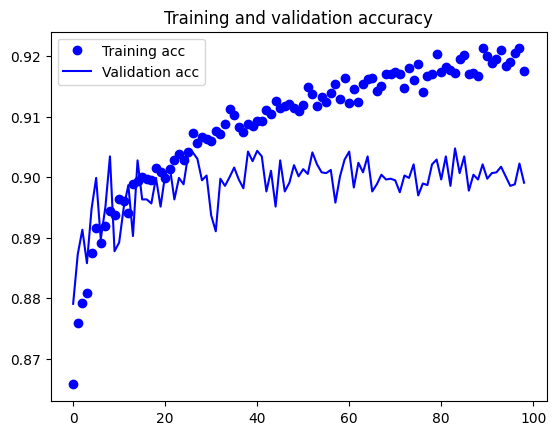

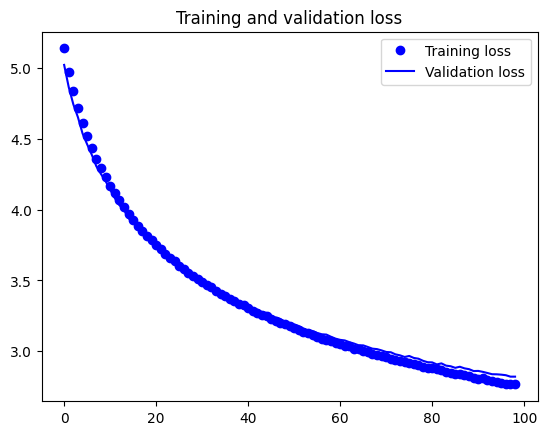

In [ ]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# loading best epoch in our model using the checkpoints

In [ ]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 85


In [ ]:
best_val_accuracy = max(val_acc_per_epoch)
#min_val_loss = min(val_loss_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-85-0.9047.keras


In [ ]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [ ]:
# Construct the full path to the best model file
best_model_path = os.path.join(model_dir, best_model_file)
best_model_path

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints\\model-85-0.9047.keras'

In [ ]:
print(best_model_path)

C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-85-0.9047.keras


In [ ]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [ ]:
os.chdir(model_dir)

In [ ]:
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'model-01-0.8847.keras',
 'model-03-0.8872.keras',
 'model-04-0.8913.keras',
 'model-06-0.8947.keras',
 'model-07-0.8999.keras',
 'model-10-0.9034.keras',
 'model-27-0.9037.keras',
 'model-28-0.9041.keras',
 'model-40-0.9042.keras',
 'model-42-0.9043.keras',
 'model-85-0.9047.keras']

In [ ]:
from keras.models import load_model
loaded_model = load_model('model-85-0.9047.keras') 
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

# Evaluate

Note: Add also F1 score if possible

In [ ]:
import time
start_time = time.time()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # modelPreT   loaded_model
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 6000 images belonging to 2 classes.
94/94 [==============================] - 25s 262ms/step - loss: 2.8911 - accuracy: 0.9005
test acc: 0.9004999995231628
test loss: 2.891073226928711


In [ ]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 25.220118522644043 Training set > seconds ---


Confution Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [ ]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

2/2 [==============================] - 0s 193ms/step


In [ ]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
len(predicted_labels)

6000

In [ ]:
from sklearn.metrics import f1_score
f1_score(true_labels, predicted_labels)

0.9008799601527478

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
cm

array([[2690,  310],
       [ 287, 2713]], dtype=int64)

Ads = 0 

Clear = 1

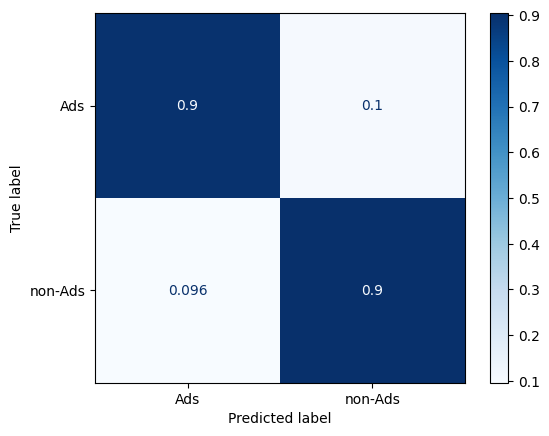

In [ ]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

In [ ]:
precision


array([0.5       , 0.89745286, 1.        ])

In [ ]:
recall

array([1.        , 0.90433333, 0.        ])

In [ ]:
thresholds

array([0, 1])

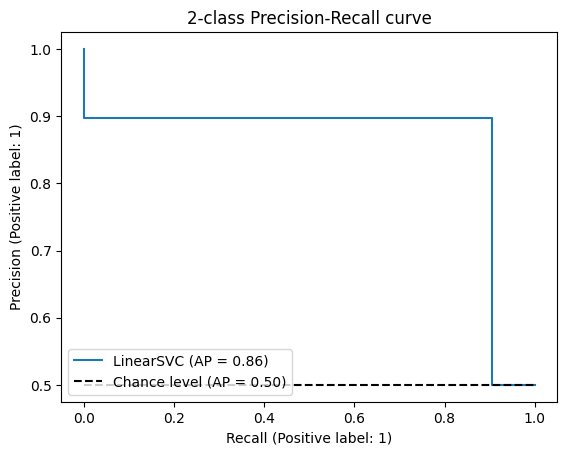

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    true_labels, predicted_labels, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8974528613959643

In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.9043333333333333

In [ ]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.900500
